In [ ]:
!pip install pandas sklearn matplotlib

In [1]:
import pandas as pd

In [2]:
titanic_data = pd.read_csv('titanic_dataset.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Drop the columns which we deem unimportant for predictions

#### Cleaning the data
Removing all the records having NaN values

In [3]:
unwanted_features = ['PassengerId', 'Name', 'Ticket', 
                     'Cabin', 'SibSp', 'Parch','Embarked']

In [4]:
titanic_data = titanic_data.drop(unwanted_features, axis=1)
titanic_data = titanic_data.dropna()
titanic_data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


#### Convert gender values to number using label encoding

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
titanic_data['Sex'] = le.fit_transform(titanic_data['Sex'])
titanic_data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,1,22.0,7.2500
1,1,1,0,38.0,71.2833
2,1,3,0,26.0,7.9250
3,1,1,0,35.0,53.1000
4,0,3,1,35.0,8.0500


#### Collecting Features

In [7]:
features = ['Pclass','Sex','Age','Fare']
titanic_features = titanic_data[features]

,Pclass,Sex,Age,Fare
0,3,1,22.0,7.2500
1,1,0,38.0,71.2833
2,3,0,26.0,7.9250
3,1,0,35.0,53.1000
4,3,1,35.0,8.0500


#### Using one-hot-encoding for Pclass

In [8]:
titanic_features = pd.get_dummies(titanic_features, columns=['Pclass'])
titanic_features.head()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,7.2500,0,0,1
1,0,38.0,71.2833,1,0,0
2,0,26.0,7.9250,0,0,1
3,0,35.0,53.1000,1,0,0
4,1,35.0,8.0500,0,0,1


#### Collecting Labels
1 - Survived <br />
0 - Did not survive

In [9]:
titanic_target = titanic_data[['Survived']]
titanic_target.head()

,Survived
0,0
1,1
2,1
3,1
4,0


#### Create training and test data using train_test_split
Spliting the data into two chunks - 80% for training and 20% for testing

In [10]:
from sklearn.model_selection import train_test_split

X_train, x_test, Y_train, y_test = train_test_split(titanic_features,
                                                    titanic_target,
                                                    test_size=0.2,
                                                    random_state=0)

X have 6 features(columns) and 571 number of data(rows)<br>
Y have 1 discrete target for all 571 entries 

In [11]:
X_train.shape, Y_train.shape

((571, 6), (571, 1))

#### We convert our data into tensors

In [12]:
import torch
import numpy as np

In [13]:
device = torch.device("cuda")

In [14]:
Xtrain_ = torch.from_numpy(X_train.values)\
               .float()\
               .cuda(device=device)
        
        
Xtest_ = torch.from_numpy(x_test.values)\
              .float()\
              .cuda(device=device)

In [15]:
Xtrain_.device

device(type='cuda', index=0)

In [16]:
Xtrain_.shape

torch.Size([571, 6])

Y parameters have shape 571 X 1 but we need those in shape 1 X 571<br>
Our loss function doesnt support multi-target, our target should be 1D Tensor
i.e 1 row containing all the labels<br>

<b>view: </b>with view we reshape the tensor (explained in module 1)<br>
view with -1<br>
If there is any situation that you don't know how many columns you want but are sure of the number of rows then you can mention it as -1, or visa-versa (You can extend this to tensors with more dimensions. Only one of the axis value can be -1).

In [17]:
Ytrain_ = torch.from_numpy(Y_train.values)\
               .view(1,-1)[0]\
               .cuda(device=device)

Ytest_ = torch.from_numpy(y_test.values)\
              .view(1,-1)[0]\
              .cuda(device=device)

In [18]:
Ytrain_.device

device(type='cuda', index=0)

In [19]:
Ytrain_.shape

torch.Size([571])

#### Creating a classifier


In [20]:
import torch.nn as nn

we have six features therefore input size is 6<br>
and we want two discrete output only

In [21]:
input_size = 6
output_size = 2
hidden_size = 10

#### Define a neural network class from which to create our model

We create a class named Net which inherits nn.Module(Base class for all neural network modules.)<br>

<b>super :</b> This is calling the \__init__() method of the parent class(nn.Module)

<b>fc1 to fc3 :</b>  Applies a linear transformation to the incoming data: y=Wx+b<br>
Parameters :<br>
in_features – size of each input sample<br>
out_features – size of each output sample<br>
bias – If set to False, the layer will not learn an additive bias. Default: True<br>

<b>Sigmoid : </b>Applies the element-wise function Sigmoid(x)= 1 / (1+exp(−x))

<b>log_softmax :</b>
Softmax applies the Softmax() function to an n-dimensional input Tensor rescaling them so that the elements of the n-dimensional output Tensor lie in the range (0,1) and sum to 1<br>
While mathematically equivalent to log(softmax(x)), doing these two operations separately is slower, and numerically unstable. This function uses an alternative formulation to compute the output and gradient correctly.<br>
Parameters:<br>
dim(int) – A dimension along which Softmax will be computed (so every slice along dim will sum to 1).


In [22]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, output_size) 
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) 
        x = self.fc3(x)
        
        return torch.log_softmax(x, dim=-1)

In [23]:
model = Net()

In [24]:
model.to(device)

Net(
  (fc1): Linear(in_features=6, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)

#### Defining optimizers and loss function

In [25]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()

#### Training the model

Optimizer.zero_grad:
* Before the backward pass, use the optimizer object to zero all of the gradients for the variables it will update (which are the learnable weights of the model)

Foward Pass:
* Predicting Y with input data X

Finding training Loss:
* Finding difference between Y_train_tensor and Y_pred using NLLLoss() function defined above


Back Propogation:
* back propogation is done by simply loss.backward() function

Working on test data<br>
predicting Y with X test data<br>
Finding test loss same as training loss, but we will not back propogate this loss<br>

Finding accuracy 
* we used .eq() function which computes element-wise equality
* returns 1 if element is equal else 0 (Hence its summation will give us total correct predictions)

We append all data in the form of list per epoch so that it will be easier for us to plot graphs


In [26]:
epoch_data = []
epochs = 1001

for epoch in range(1, epochs):

    optimizer.zero_grad()
    Ypred = model(Xtrain_)

    loss = loss_fn(Ypred , Ytrain_)
    loss.backward()

    optimizer.step()
        
    Ypred_test = model(Xtest_)
    loss_test = loss_fn(Ypred_test, Ytest_)
    
    _,pred = Ypred_test.data.max(1)
    
    accuracy = pred.eq(Ytest_.data).sum().item() / y_test.values.size
    epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), accuracy])
    
    if epoch % 100 == 0:
        print ('epoch - %d (%d%%) train loss - %.2f test loss - %.2f accuracy - %.4f'\
               % (epoch, epoch/150 * 10 , loss.data.item(), loss_test.data.item(), accuracy))

epoch - 100 (6%) train loss - 0.63 test loss - 0.64 accuracy - 0.5734
epoch - 200 (13%) train loss - 0.59 test loss - 0.59 accuracy - 0.6783
epoch - 300 (20%) train loss - 0.55 test loss - 0.54 accuracy - 0.7413
epoch - 400 (26%) train loss - 0.49 test loss - 0.48 accuracy - 0.7902
epoch - 500 (33%) train loss - 0.45 test loss - 0.42 accuracy - 0.8322
epoch - 600 (40%) train loss - 0.43 test loss - 0.41 accuracy - 0.8112
epoch - 700 (46%) train loss - 0.42 test loss - 0.40 accuracy - 0.8182
epoch - 800 (53%) train loss - 0.41 test loss - 0.41 accuracy - 0.8182
epoch - 900 (60%) train loss - 0.40 test loss - 0.41 accuracy - 0.8392
epoch - 1000 (66%) train loss - 0.39 test loss - 0.42 accuracy - 0.8322


#### Plotting

Converting all our data in dataframes to plot it

In [27]:
df_epochs_data = pd.DataFrame(epoch_data, 
                              columns=["epoch", "train_loss", "test_loss", "accuracy"])

In [28]:
import matplotlib.pyplot as plt

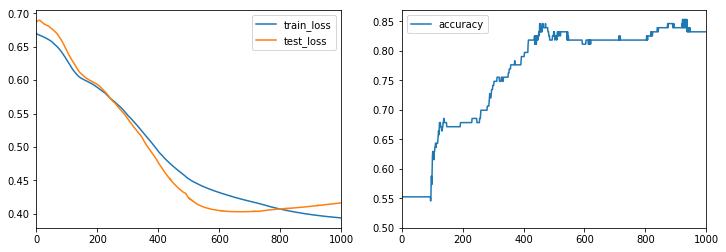

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df_epochs_data[["train_loss", "test_loss"]].plot(ax=ax1)
df_epochs_data[["accuracy"]].plot(ax=ax2)
plt.ylim(bottom=0.5)

plt.show()

#### Checking output using sample data
since test data is not at all used for training, we can use that data for sample check

In [30]:
print("sample train data = ",x_test.values[5])
print("sample target data = ",y_test.values[5])

sample train data =  [  1.    36.    24.15   0.     0.     1.  ]
sample target data =  [0]


In [31]:
import numpy as np

#### Converting the features to a numpy array and then a tensor

In [32]:
sample = np.array(x_test.values[5]) 
sample_tensor = torch.from_numpy(sample).float().cuda(device)

#### Get the prediction for the sample data

In [33]:
out = model(sample_tensor)
out

tensor([-0.1385, -2.0453], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

#### Picking target with the highest probability

In [34]:
_, predicted = torch.max(out.data, -1)

In [35]:
if predicted.item() == 0: 
    print("Did not survive - ", predicted.item())
elif predicted.item() == 1:
    print("Survived - ", predicted.item())

Did not survive -  0
